# ICAPS24 SkDecide Tutorial: Implementing a scikit-decide solver embedding the JaxPlan and GurobiPlan planners and solving RDDL-based scikit-decide domains

This tutorial will demonstrate how to create a custom 

In [ ]:
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py

from install_skdecide import install_skdecide
install_skdecide(using_nightly_version=True, force_reinstall=False)

In [4]:
# We have dependency problems between ortools installed with scikit-decide and pRDDLGym-jax
# So we uninstall ortools which we don't need in this notebook
!pip uninstall -y ortools
!pip --default-timeout=1000 install rddlrepository pyRDDLGym-jax
!pip --default-timeout=1000 install gurobipy git+https://github.com/pyrddlgym-project/pyRDDLGym-gurobi

  Cloning https://github.com/pyrddlgym-project/pyRDDLGym-gurobi to /private/var/folders/nh/hzyt86t51fxcj7rdyzbqhf280000gn/T/pip-req-build-y2p8qys_
  Running command git clone --filter=blob:none --quiet https://github.com/pyrddlgym-project/pyRDDLGym-gurobi /private/var/folders/nh/hzyt86t51fxcj7rdyzbqhf280000gn/T/pip-req-build-y2p8qys_
  Resolved https://github.com/pyrddlgym-project/pyRDDLGym-gurobi to commit 3efa66628bf042f2f1e02f3ca26f11b97fe312bc
  Preparing metadata (setup.py) ... done
  Created wheel for pyRDDLGym-gurobi: filename=pyRDDLGym_gurobi-0.1-py3-none-any.whl size=17178 sha256=998261965fe8a7f728df2c69efbd87ad37aecc0f6f41dbc7b00415c4d22e879f
  Stored in directory: /private/var/folders/nh/hzyt86t51fxcj7rdyzbqhf280000gn/T/pip-ephem-wheel-cache-ez8srzra/wheels/98/98/b8/351baee6b55a27be027e8a6f9db95a627da54223bf911ffb5b
Successfully built pyRDDLGym-gurobi


![Solver code generator](images/skdecide_solver_generator.png)

```python

from typing import *

from skdecide import *
from skdecide.builders.domain import *
from skdecide.builders.solver import *


class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    pass


class MySolver(DeterministicPolicySolver, FromInitialState):
    T_domain = D
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        pass
    
    def _get_next_action(self, observation: D.T_observation) -> D.T_event:
        pass
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        pass
```

In [5]:
from typing import Any

from skdecide.core import TransitionOutcome, Value, Space
from skdecide.domains import RLDomain
from skdecide.builders.domain import UnrestrictedActions, FullyObservable, Renderable
from skdecide.hub.space.gym import DictSpace, GymSpace, MultiDiscreteSpace
from skdecide.utils import rollout

import pyRDDLGym
from pyRDDLGym.core.simulator import RDDLSimulator
from pyRDDLGym.core.env import RDDLEnv
from pyRDDLGym.core.visualizer.viz import BaseViz
from pyRDDLGym.core.visualizer.chart import ChartVisualizer

from IPython.display import clear_output
%matplotlib notebook

class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = DictSpace  # Type of states
    T_observation = T_state  # Type of observations
    T_event = MultiDiscreteSpace  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class RDDLDomain(D):

    def __init__(self,
                 rddl_domain: str,
                 rddl_instance: str,
                 backend: RDDLSimulator = RDDLSimulator,
                 base_class: RDDLEnv = RDDLEnv,
                 visualizer: BaseViz = ChartVisualizer,
                 movie_name: str = None,
                 max_frames=100):
        self.rddl_gym_env = pyRDDLGym.make(rddl_domain,
                                           rddl_instance,
                                           backend=backend,
                                           base_class=base_class,
                                           enforce_action_constraints=True,
                                          vectorized=True)
        self.movie_name = movie_name
        if movie_name is not None:
            self.movie_path = os.path.join('rddl_movies', movie_name)
            if not os.path.exists(self.movie_path):
                os.makedirs(self.movie_path)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            if os.path.exists(tmp_pngs):
                shutil.rmtree(tmp_pngs)
            os.makedirs(tmp_pngs)
            self.movie_gen = MovieGenerator(tmp_pngs, movie_name, max_frames=max_frames)
            self.rddl_gym_env.set_visualizer(visualizer, self.movie_gen)
        else:
            self.movie_gen = None
            self.rddl_gym_env.set_visualizer(visualizer)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        next_state, reward, terminated, truncated, _ = self.rddl_gym_env.step(action)
        termination = terminated or truncated
        if termination and self.movie_gen is not None:
            self.movie_gen.save_animation(self.movie_name)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            shutil.move(os.path.join(tmp_pngs, self.movie_name + '.gif'),
                        os.path.join(self.movie_path, self.movie_name + '_' +
                                     str(dt.now().strftime("%Y%m%d-%H%M%S")) +
                                     '.gif'))
        return TransitionOutcome(
            state=next_state, value=Value(reward=reward), termination=termination
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        return GymSpace(self.rddl_gym_env.action_space)

    def _state_reset(self) -> D.T_state:
        # SkDecide only needs the state, not the info
        return self.rddl_gym_env.reset()[0]

    def _get_observation_space_(self) -> Space[D.T_observation]:
        return GymSpace(self.rddl_gym_env.observation_space)

    def _render_from(self, memory: D.T_state = None, **kwargs: Any) -> Any:
        # We do not want the image to be displayed in a pygame window, but rather in this notebook
        rddl_gym_img = self.rddl_gym_env.render(to_display=False)
        clear_output(wait=True)
        display(rddl_gym_img)

## Random Agent

In [34]:
from typing import Callable, Optional, Dict, Any

from skdecide.solvers import DeterministicPolicySolver
from skdecide.builders.solver import FromInitialState

from pyRDDLGym.core.policy import RandomAgent

class D(RDDLDomain):
    pass

class RDDLRandomSolver(DeterministicPolicySolver, FromInitialState):
    T_domain = D

    def __init__(self, domain_factory: Callable[[], RDDLDomain]):
        DeterministicPolicySolver.__init__(self, domain_factory=domain_factory)
        self._domain = domain_factory()

    @classmethod
    def _check_domain_additional(cls, domain: D) -> bool:
        return hasattr(domain, 'rddl_gym_env')      
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        self.controller = RandomAgent(action_space = self._domain.rddl_gym_env.action_space,
                                      num_actions = self._domain.rddl_gym_env.max_allowed_actions)
    
    def _get_next_action(self, observation: D.T_observation) -> D.T_event:
        return self.controller.sample_action(observation)
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        return True

In [35]:
from rddlrepository.core.manager import RDDLRepoManager
from rddlrepository.archive.standalone.Quadcopter.QuadcopterViz import QuadcopterVisualizer
manager = RDDLRepoManager(rebuild=True)
problem_info = manager.get_problem("Quadcopter")
problem_visualizer = QuadcopterVisualizer

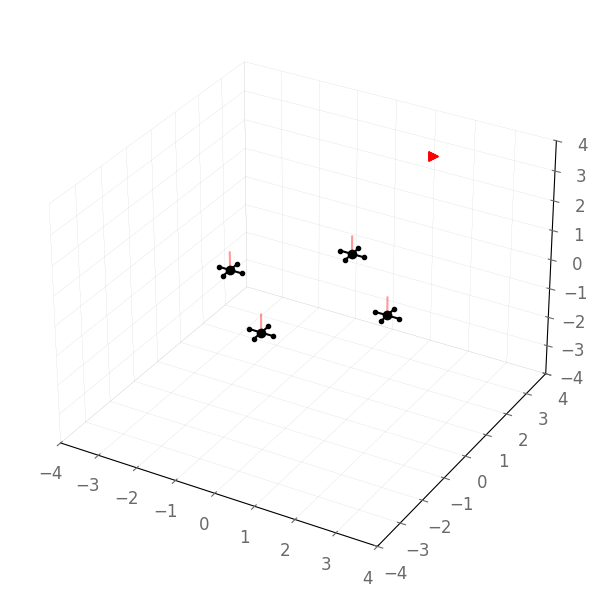

In [36]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger("skdecide.utils").setLevel(logging.INFO)

domain_factory_random_agent = lambda: RDDLDomain(rddl_domain=problem_info.get_domain(),
                                                 rddl_instance=problem_info.get_instance(1),
                                                 visualizer = problem_visualizer)
domain = domain_factory_random_agent()
domain.reset()
domain.render()

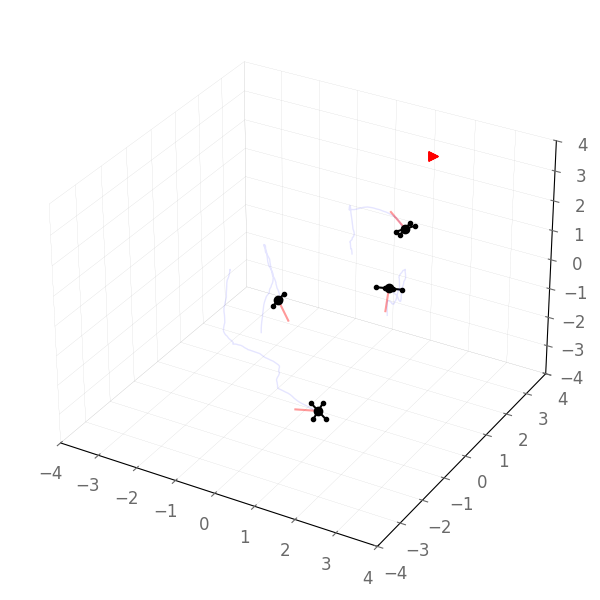

In [11]:
from skdecide.utils import rollout

assert RDDLRandomSolver.check_domain(domain_factory_random_agent())

with RDDLRandomSolver(domain_factory=domain_factory_random_agent) as solver:
    solver.solve()
    rollout(
        domain_factory_random_agent(),
        solver,
        max_steps=100,
        render=True,
        max_framerate=5,
        verbose=False,
    )

## JAX Agent

In [20]:
from typing import Callable, Optional, Dict, Any

from skdecide.solvers import DeterministicPolicySolver
from skdecide.builders.solver import FromInitialState

from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOfflineController, JaxOnlineController
from pyRDDLGym_jax.core.planner import load_config

class D(RDDLDomain):
    pass

class RDDLJaxSolver(DeterministicPolicySolver, FromInitialState):
    T_domain = D

    def __init__(self,
                 domain_factory: Callable[[], RDDLDomain],
                 config: Optional[str] = None):
        DeterministicPolicySolver.__init__(self, domain_factory=domain_factory)
        self._domain = domain_factory()
        if config is not None:
            self.planner_args, _, self.train_args = load_config(config)

    @classmethod
    def _check_domain_additional(cls, domain: D) -> bool:
        return hasattr(domain, 'rddl_gym_env')          
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        planner = JaxBackpropPlanner(rddl=self._domain.rddl_gym_env.model,
                                     **(self.planner_args if self.planner_args is not None else {}))
        self.controller = JaxOfflineController(planner,
                                               **(self.train_args if self.train_args is not None else {}))
    
    def _get_next_action(self, observation: D.T_observation) -> D.T_event:
        return self.controller.sample_action(observation)
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        return True

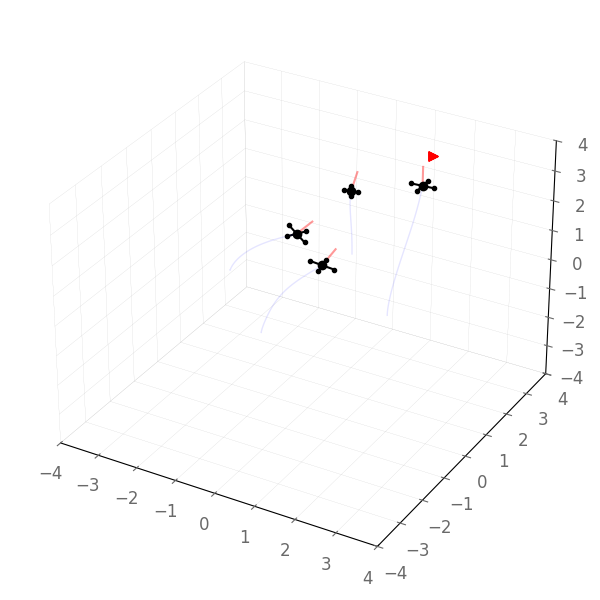

In [21]:
from pyRDDLGym_jax.core.simulator import JaxRDDLSimulator
import os

if not os.path.exists('Quadcopter_slp.cfg'):
    !wget https://raw.githubusercontent.com/pyrddlgym-project/pyRDDLGym-jax/main/pyRDDLGym_jax/examples/configs/Quadcopter_slp.cfg

domain_factory_jax_agent = lambda: RDDLDomain(rddl_domain=problem_info.get_domain(),
                                              rddl_instance=problem_info.get_instance(1),
                                              visualizer = problem_visualizer,
                                              backend=JaxRDDLSimulator)

assert RDDLJaxSolver.check_domain(domain_factory_jax_agent())

with RDDLJaxSolver(domain_factory=domain_factory_jax_agent,
                   config='Quadcopter_slp.cfg') as solver:
    solver.solve()
    rollout(
        domain_factory_jax_agent(),
        solver,
        max_steps=1000,
        render=True,
        max_framerate=5,
        verbose=False,
    )

## Gurobi Agent

In [37]:
from typing import Callable, Optional, Dict, Any

from skdecide.solvers import DeterministicPolicySolver
from skdecide.builders.solver import FromInitialState

from pyRDDLGym_gurobi.core.planner import GurobiStraightLinePlan, GurobiOnlineController

class D(RDDLDomain):
    pass

class RDDLGurobiSolver(DeterministicPolicySolver, FromInitialState):
    T_domain = D

    def __init__(self,
                 domain_factory: Callable[[], RDDLDomain],
                 config: Optional[str] = None,
                 rollout_horizon=5):
        DeterministicPolicySolver.__init__(self, domain_factory=domain_factory)
        self._domain = domain_factory()
        self._rollout_horizon = rollout_horizon
        if config is not None:
            self.planner_args, _, self.train_args = load_config(config)

    @classmethod
    def _check_domain_additional(cls, domain: D) -> bool:
        return hasattr(domain, 'rddl_gym_env')          
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        plan = GurobiStraightLinePlan()
        self.controller = GurobiOnlineController(rddl=self._domain.rddl_gym_env.model,
                                                 plan=plan,
                                                 rollout_horizon=self._rollout_horizon,
                                                 model_params={'NonConvex': 2, 'OutputFlag': 1})
    
    def _get_next_action(self, observation: D.T_observation) -> D.T_event:
        return self.controller.sample_action(observation)
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        return True

In [41]:
problem_info = manager.get_problem("PowerGen_Discrete")
problem_visualizer = ChartVisualizer

domain_factory_gurobi_agent = lambda: RDDLDomain(rddl_domain=problem_info.get_domain(),
                                                 rddl_instance=problem_info.get_instance(0),
                                                 visualizer = problem_visualizer)

assert RDDLGurobiSolver.check_domain(domain_factory_gurobi_agent())

with RDDLGurobiSolver(domain_factory=domain_factory_gurobi_agent) as solver:
    solver.solve()
    rollout(
        domain_factory_gurobi_agent(),
        solver,
        max_steps=100,
        render=True,
        max_framerate=5,
        verbose=False,
    )

Set parameter ServerPassword
Set parameter TokenServer to value "10.102.130.240"


KeyboardInterrupt: 

## Solving with IW

In [31]:
from skdecide.hub.domain.gym import (
    GymDiscreteActionDomain,
    GymPlanningDomain,
    GymWidthDomain,
)

from pyRDDLGym_rl.core.env import SimplifiedActionRDDLEnv

class D(GymPlanningDomain, GymWidthDomain, GymDiscreteActionDomain):
    pass

class RDDLDomainForWidthSolvers(D):
    def __init__(
        self,
        rddl_domain: str,
        rddl_instance: str,
        continuous_feature_fidelity: int = 3,
        discretization_factor: int = 2,
        branching_factor: int = None,
        max_depth: int = 1000,
        visualizer: BaseViz = ChartVisualizer,
        movie_name: str = None,
        max_frames=100
    ) -> None:
        self.rddl_gym_env = pyRDDLGym.make(rddl_domain,
                                           rddl_instance,
                                           base_class=SimplifiedActionRDDLEnv,
                                           enforce_action_constraints=True)
        GymPlanningDomain.__init__(
            self,
            gym_env=self.rddl_gym_env,
            termination_is_goal=True,
            max_depth=max_depth,
        )
        GymDiscreteActionDomain.__init__(
            self,
            discretization_factor=discretization_factor,
            branching_factor=branching_factor,
        )
        GymWidthDomain.__init__(
            self, continuous_feature_fidelity=continuous_feature_fidelity
        )
        self.rddl_gym_env._max_episode_steps = max_depth

    def state_features(self, s):
        return self.bee1_features(s)

In [32]:
from skdecide.hub.solver.iw import IW

domain_factory = lambda alg_name=None: RDDLDomainForWidthSolvers(rddl_domain=problem_info.get_domain(),
                                                                 rddl_instance=problem_info.get_instance(0),
                                                                 visualizer=problem_visualizer,
                                                                 movie_name='Quadcopter-' + alg_name if alg_name is not None else None)

domain = domain_factory()
            
# assert IW.check_domain(domain)
solver_factory = lambda: IW(
    domain_factory=domain_factory,
    state_features=lambda d, s: d.state_features(s),
    node_ordering=lambda a_gscore, a_novelty, a_depth, b_gscore, b_novelty, b_depth: a_novelty > b_novelty
)
with solver_factory() as solver:
    solver.solve()
    rollout(
        domain_factory('IW'),
        solver,
        max_steps=500,
        render=True
    )

[2024-05-29 11:25:17.087] [info] Running sequential IW solver from state {'x': array([0.]), 'y': array([0.]), 'z': array([0.]), 'xdot': array([0.]), 'ydot': array([0.]), 'zdot': array([0.]), 'phi': array([0.]), 'theta': array([0.]), 'psi': array([0.]), 'phidot': array([0.]), 'thetadot': array([0.]), 'psidot': array([0.])}
[2024-05-29 11:25:17.087] [info] Running sequential IW(1) solver from state {'x': array([0.]), 'y': array([0.]), 'z': array([0.]), 'xdot': array([0.]), 'ydot': array([0.]), 'zdot': array([0.]), 'phi': array([0.]), 'theta': array([0.]), 'psi': array([0.]), 'phidot': array([0.]), 'thetadot': array([0.]), 'psidot': array([0.])}
Current depth: 1 / 1000
Current depth: 2 / 1000
Current depth: 3 / 1000
Current depth: 4 / 1000
Current depth: 5 / 1000
Current depth: 6 / 1000
Current depth: 7 / 1000
Current depth: 8 / 1000
Current depth: 9 / 1000
Current depth: 10 / 1000
Current depth: 11 / 1000
Current depth: 12 / 1000
Current depth: 13 / 1000
Current depth: 14 / 1000
Current 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1061ad7b0>>
Traceback (most recent call last):
  File "/Users/teichteil_fl/Projects/SkDecide/skdecide-icaps24-tutorial/.env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Current depth: 185 / 1000
Current depth: 186 / 1000
Current depth: 187 / 1000
Current depth: 188 / 1000
Current depth: 189 / 1000
Current depth: 190 / 1000
Current depth: 191 / 1000
Current depth: 192 / 1000
Current depth: 193 / 1000
Current depth: 194 / 1000
Current depth: 195 / 1000
Current depth: 196 / 1000
Current depth: 197 / 1000
Current depth: 198 / 1000
Current depth: 199 / 1000
Current depth: 200 / 1000
[2024-05-29 11:30:52.924] [error] SKDECIDE exception when getting next state from state {'x': array([0.602084]), 'y': array([0.87255208]), 'z': array([-158.76607139]), 'xdot': array([2.33799967]), 'ydot': array([8.6315498]), 'zdot': array([-16.57072269]), 'phi': array([10773.56632775]), 'theta': array([8705.27235727]), 'psi': array([8721.09407629]), 'phidot': array([-1000000.]), 'thetadot': array([-1000000.]), 'psidot': array([-1000000.])} and applying action [-10000. -10000. -10000. -10000.]: RDDLEpisodeAlreadyEndedError: The step() function has been called even though the cur

RDDLEpisodeAlreadyEndedError: The step() function has been called even though the current episode has terminated or truncated: please call reset().